In [27]:
import tkinter as tk
from tkinter import filedialog
import os
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D,Conv1DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 符号付に変換する関数
def unsigned2signed(x):
    if x > 32767:
        return x - 65536
    return x

In [5]:
# 学習データの読み込み
def load_binary_data(folder_path):
    data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in data or data_index > data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    file_names.append(file_name)  # ファイル名をリストに追加

    return data, file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# フォルダを選択するためのダイアログを表示
folder_selected = filedialog.askdirectory()

if folder_selected:
    print("選択したフォルダ:", folder_selected)
    # フォルダ内のデータを読み込む
    data, data_filenames = load_binary_data(folder_selected)
    if data:
        print("データの読み込みが完了しました。")
    else:
        print("データが見つかりませんでした。")
else:
    print("フォルダが選択されませんでした。")

# Tkinterを終了
root.quit()

sensor_data_dict = {}  # センサーデータを格納するディクショナリ
for key, sensor_data in data.items():
    extension_number = sensor_data[-1]  # 拡張子の番号
    for i, sensor_value in enumerate(sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if sensor_key not in sensor_data_dict:
            sensor_data_dict[sensor_key] = []  # キーが存在しない場合、空のリストを作成
        sensor_data_dict[sensor_key].append(sensor_value)  # キーに対応するリストにセンサーデータを追加

# データの形状を決定
num_samples = len(sensor_data_dict)
num_sensors = 8  # センサーの数

# 2次元のリストを初期化
data_matrix = [[None] * num_sensors for _ in range(num_samples)]

# センサーデータのみを保存する新しい変数を作成
sensor_data = []

# データを2次元リストと新しい変数に配置
for i, (key, sensor_values) in enumerate(sensor_data_dict.items()):
    data_matrix[i] = [key] + sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    sensor_data.append(sensor_values)  # センサーデータのリストを新しい変数に格納

# data_matrix には各キー（インデックス）に対応するセンサーデータが格納されています
# sensor_data にはセンサーデータのリストのみが格納されています

選択したフォルダ: C:/Users/r-fujita/Desktop/FCC_E-2316B
データの読み込みが完了しました。


In [6]:
# テストデータの読み込み
def load_test_data(test_folder_path):
    test_data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    test_file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(test_folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in test_data or data_index > test_data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    test_data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    test_file_names.append(file_name)  # ファイル名をリストに追加

    return test_data, test_file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# テストデータのフォルダを選択するためのダイアログを表示
test_folder_path = filedialog.askdirectory()

if test_folder_path:
    print("選択したテストデータのフォルダ:", test_folder_path)
    # テストデータを読み込む
    test_data, test_data_filenames = load_test_data(test_folder_path)
    if test_data:
        print("テストデータの読み込みが完了しました。")
    else:
        print("テストデータが見つかりませんでした.")
else:
    print("テストデータのフォルダが選択されませんでした.")

test_sensor_data_dict = {}  # テストデータのセンサーデータを格納するディクショナリ
for key, test_sensor_data in test_data.items():
    extension_number = test_sensor_data[-1]  # 拡張子の番号
    for i, test_sensor_value in enumerate(test_sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        test_sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if test_sensor_key not in test_sensor_data_dict:
            test_sensor_data_dict[test_sensor_key] = []  # キーが存在しない場合、空のリストを作成
        test_sensor_data_dict[test_sensor_key].append(test_sensor_value)  # キーに対応するリストにテストデータのセンサーデータを追加

# データの形状を決定
num_test_samples = len(test_sensor_data_dict)
num_sensors = 8  # センサーの数

# テストデータの2次元のリストを初期化
test_data_matrix = [[None] * num_sensors for _ in range(num_test_samples)]

# テストデータのセンサーデータのみを保存する新しい変数を作成
test_sensor_data = []

# テストデータを2次元リストと新しい変数に配置
for i, (key, test_sensor_values) in enumerate(test_sensor_data_dict.items()):
    test_data_matrix[i] = [key] + test_sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    test_sensor_data.append(test_sensor_values)  # テストデータのセンサーデータのリストを新しい変数に格納

# test_data_matrix には各キー（インデックス）に対応するテストデータのセンサーデータが格納されています
# test_sensor_data にはテストデータのセンサーデータのリストのみが格納されています

選択したテストデータのフォルダ: C:/Users/r-fujita/Desktop/テストデータ_FCC_E-2316A
テストデータの読み込みが完了しました。


In [7]:
# データの標準化
# 学習データ
sensor_data_sca = []
for i in range(len(sensor_data)):
    mean = np.mean(sensor_data[i])
    std = np.std(sensor_data[i])

    #標準化処理を実行
    standardization_sensor_data = (sensor_data[i] - mean) / std
    sensor_data_sca.append(standardization_sensor_data)

# テストデータ
test_sensor_data_sca = []
for i in range(len(test_sensor_data)):
    mean = np.mean(test_sensor_data[i])
    std = np.std(test_sensor_data[i])

    #標準化処理を実行
    standardization_test_sensor_data = (test_sensor_data[i] - mean) / std
    test_sensor_data_sca.append(standardization_test_sensor_data)


# データ長を揃える
# 最大の波形データ長を見つける
max_length = max(max(len(waveform) for waveform in sensor) for sensor in sensor_data_sca + test_sensor_data_sca)

# ゼロパディングを行う
padded_sensor_data = []
for sensor in sensor_data_sca:
    padded_sensor = []
    for waveform in sensor:
        # ゼロパディング
        padding = [0] * (max_length - len(waveform))
        padded_waveform = np.concatenate((waveform, padding)) if len(padding) > 0 else waveform
        padded_sensor.append(padded_waveform)
    padded_sensor_data.append(padded_sensor)

# 同じことをtest_sensor_dataにも適用
padded_test_sensor_data = []
for sensor in test_sensor_data_sca:
    padded_sensor = []
    for waveform in sensor:
        # ゼロパディング
        padding = [0] * (max_length - len(waveform))
        padded_waveform = np.concatenate((waveform, padding)) if len(padding) > 0 else waveform
        padded_sensor.append(padded_waveform)
    padded_test_sensor_data.append(padded_sensor)

# 学習データとテストデータをNumPyの配列に変換
padded_sensor_data = np.array(padded_sensor_data)
padded_test_sensor_data = np.array(padded_test_sensor_data)

# 中間の次元（次元1）を削除して2次元に reshape
#padded_sensor_data = np.squeeze(padded_sensor_data, axis=1)
#padded_test_sensor_data = np.squeeze(padded_test_sensor_data, axis=1)

# データの変形
#padded_sensor_data = padded_sensor_data.reshape(int(len(sensor_data)/num_sensors),num_sensors,max_length)
#padded_test_sensor_data = padded_test_sensor_data.reshape(int(len(test_sensor_data)/num_sensors),num_sensors,max_length)
#padded_sensor_data = padded_sensor_data.reshape(int(len(sensor_data)/2),2,max_length)
#padded_test_sensor_data = padded_test_sensor_data.reshape(int(len(test_sensor_data)/2),2,max_length)

In [25]:
def stacked_what_where_autoencoder(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(32, 3, activation='selu', padding='same')(inputs)
    pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)  # 時間軸方向のみにプーリングを行う
    conv2 = Conv1D(64, 3, activation='selu', padding='same')(pool1)
    pool2 = MaxPooling1D(pool_size=2, padding='same')(conv2)  # 時間軸方向のみにプーリングを行う

    # Decoder
    up1 = UpSampling1D(2)(conv2)
    conv3 = Conv1DTranspose(32, 3, activation='selu', padding='same')(up1)
    up2 = UpSampling1D(1)(conv3) 
    decoded = Conv1DTranspose(input_shape[-1], 3, activation='selu', padding='same')(up2)

    # Autoencoder Model
    autoencoder = Model(inputs, decoded)
    return autoencoder

In [28]:
# 入力データの形状を取得
input_shape = padded_sensor_data.shape[1:]  # データの形状

# Stacked What-Where Autoencoderを構築
autoencoder = stacked_what_where_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# モデルのサマリを表示
autoencoder.summary()

# モデルの学習
history = autoencoder.fit(padded_sensor_data, padded_sensor_data, epochs=50, batch_size=16, shuffle=True, verbose=1)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 14784)]        0         
                                                                 
 conv1d_14 (Conv1D)          (None, 1, 32)             1419296   
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 1, 64)             6208      
                                                                 
 up_sampling1d_7 (UpSampling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 2, 32)            6176

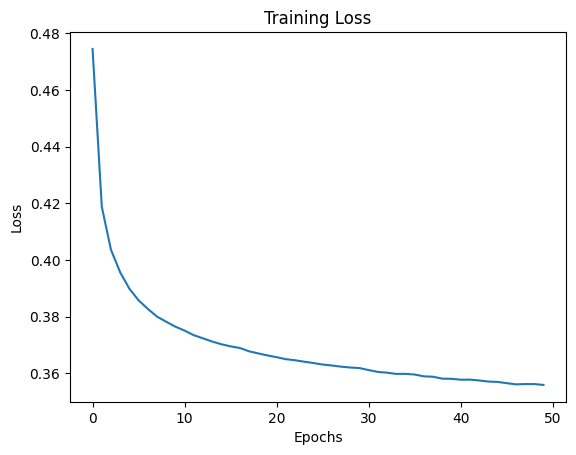

<Figure size 640x480 with 0 Axes>

In [29]:
# 損失関数の値を取得
loss = history.history['loss']

# エポックごとの損失関数の変化をプロット
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 画像として保存
plt.savefig('training_loss.png')  # 任意のファイル名と拡張子を指定して保存

226/226 [==============================] - 1s 4ms/step


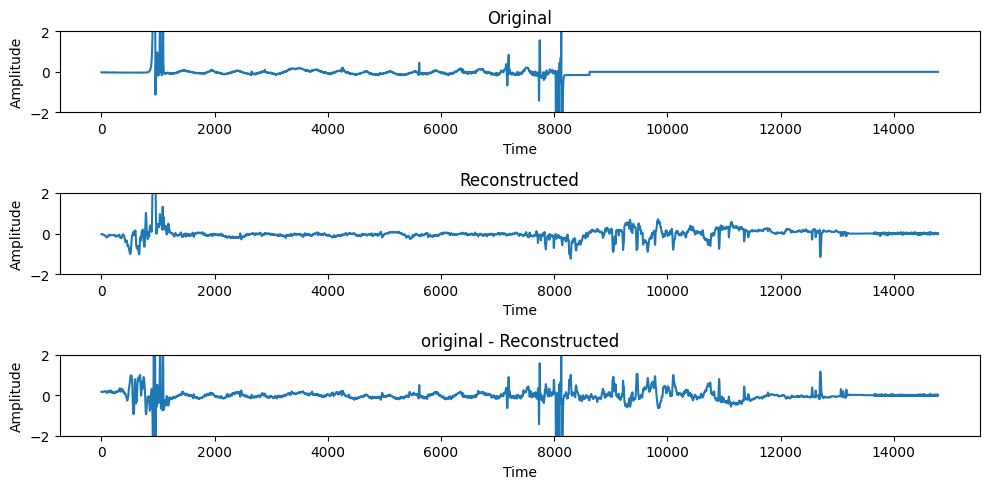

In [30]:
# テストデータを使って再構築を行う
reconstructed_test_data = autoencoder.predict(padded_test_sensor_data)

# いくつかのデータをプロットして可視化
import matplotlib.pyplot as plt

n = 10  # 表示するデータ
plt.figure(figsize=(10, 5))

# オリジナルのデータをプロット
ax = plt.subplot(3, 1, 1)
plt.plot(padded_test_sensor_data[n,0,:])
plt.title("Original")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# 再構築されたデータをプロット
ax = plt.subplot(3, 1, 2)
plt.plot(reconstructed_test_data[n,0,:])
plt.title("Reconstructed")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# オリジナル-再構築
ax = plt.subplot(3, 1, 3)
plt.plot(padded_test_sensor_data[n,0,:] - reconstructed_test_data[n,1,:])
plt.title("original - Reconstructed")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

plt.tight_layout()
plt.show()



211/211 [==============================] - 1s 4ms/step


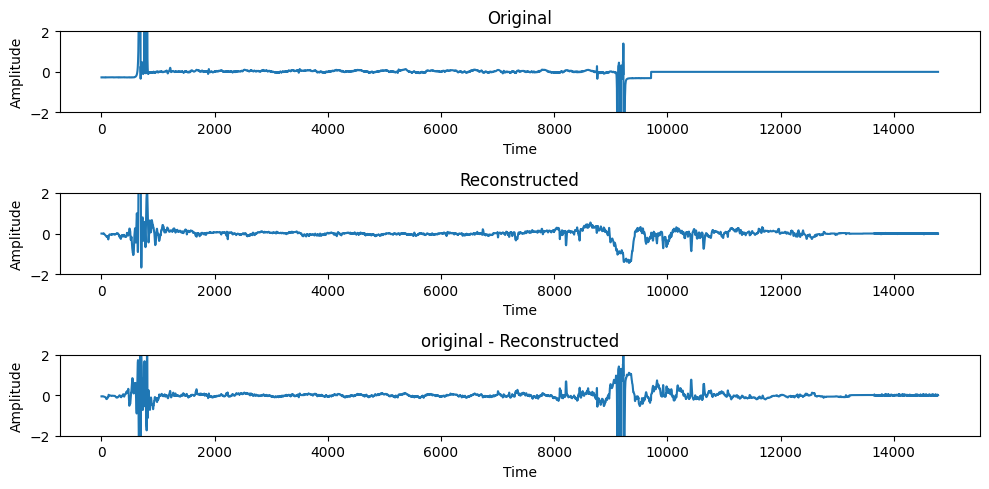

In [22]:
# 学習データを使って再構築を行う
reconstructed_data = autoencoder.predict(padded_sensor_data)
n = 0  # 表示するデータ
plt.figure(figsize=(10, 5))

# オリジナルのデータをプロット
ax = plt.subplot(3, 1, 1)
plt.plot(padded_sensor_data[n,0,:])
plt.title("Original")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# 再構築されたデータをプロット
ax = plt.subplot(3, 1, 2)
plt.plot(reconstructed_data[n,0,:])
plt.title("Reconstructed")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# オリジナル-再構築
ax = plt.subplot(3, 1, 3)
plt.plot(padded_sensor_data[n,0,:] - reconstructed_data[n,1,:])
plt.title("original - Reconstructed")
plt.ylim(-2,2)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

plt.tight_layout()
plt.show()


In [14]:
# テストデータの異常度スコアを計算
predictions = autoencoder.predict(padded_test_sensor_data)  # テストデータをモデルに入力して再構成
mse = np.mean(np.square(padded_test_sensor_data - predictions), axis=(1, 2))  # テストデータと再構成データの平均二乗誤差を計算

113/113 [==============================] - 1s 5ms/step


In [31]:
# 異常度の閾値を設定
threshold = 0.7
# 異常と判断されたデータのインデックスを取得
anomalies_idx = np.where(mse > threshold)[0]
anomalies_idx = anomalies_idx * 2 #テストデータは2チャンネルなので、sensor_data_dictのキーと合わせるために二倍する
print("異常と判断されたデータのインデックス:", anomalies_idx)

異常と判断されたデータのインデックス: [  48   50   52   96  100  144  146  148  266  268  656  658  660 1592
 1594 1596 2096 2098 2130 2136 2138 2140 2164 2264 2266 2268 3164 3264
 3268 3304 3306 3308 3504 3506 3508 3584 3600 3602 3604 4024 4026 4028
 4152 4154 4156 4168 4170 4192 4194 4196 4296 4298 4300 4328 4330 4332
 4568 4570 4572 4576 4578 4580 4796 4876 5092 5240 5242 5244 5288 5290
 5292 5416 5418 5420 5554 5556 5604 5952 5954 5956 6208 6260 6360 6362
 6364 6540 7056 7058 7060 7072 7074 7076 7096 7098 7100]


In [29]:
# 異常と判断されたデータのインデックスから対応するデータのフルパス（dictのキー）を取得
anomalies_paths = [list(test_sensor_data_dict.keys())[idx] for idx in anomalies_idx]
#print("異常と判断されたデータのフルパス:", anomalies_paths)
# 異常と判断されたデータのフルパスをDataFrameに追加
data = {'異常と判断されたデータのフルパス': anomalies_paths}
df = pd.DataFrame(data)

# Excelファイルに書き出し
df.to_excel('SWWAE_ET_1.xlsx', index=False)

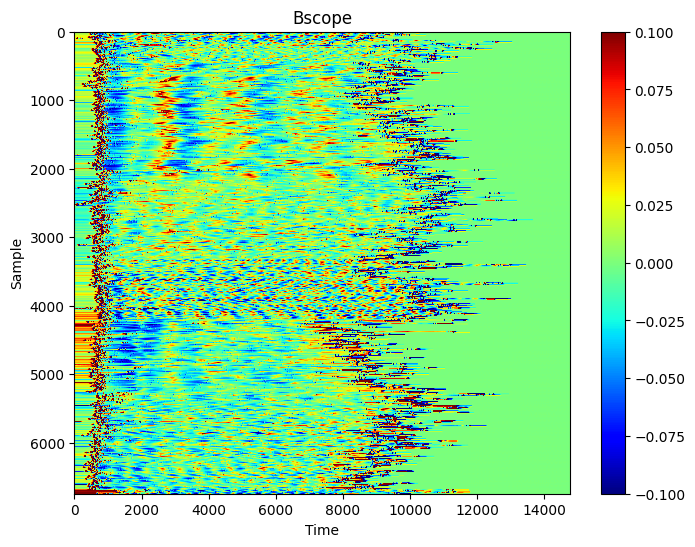

In [32]:
plt.figure(figsize=(8, 6))
a = padded_sensor_data.reshape((int(len(sensor_data)),max_length))
plt.imshow(a, aspect='auto', cmap='jet', vmin=-0.1, vmax=0.1)  # vminとvmaxで表示範囲を指定
#plt.imshow(a[6680:6690,:], aspect='auto', cmap='jet', vmin=-0.2, vmax=0.2)  # vminとvmaxで表示範囲を指定

plt.colorbar()  #カラーバーを表示
plt.title('Bscope')
plt.xlabel('Time')
plt.ylabel('Sample')
plt.show()

In [10]:
input_shape

(14784,)

In [42]:
# モデルを保存
autoencoder.save("model\\1120autoencoder_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

# モデルを読み込む
loaded_model = load_model("model\\autoencoder_model.h5")

In [11]:
# 画像として保存
plt.savefig('training_loss.png')  # 任意のファイル名と拡張子を指定して保存

<Figure size 640x480 with 0 Axes>

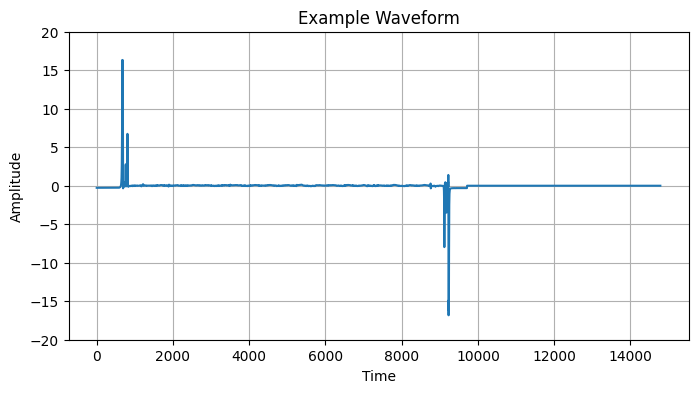

In [35]:
# 例として最初のセンサーの最初の波形をプロットする
plt.figure(figsize=(8, 4))
plt.plot(padded_sensor_data[0,0,:])  # 最初のセンサー、最初の波形をプロット

plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル
plt.title('Example Waveform')  # グラフのタイトル
plt.ylim(-20,20)
plt.grid(True)  # グリッドを表示
plt.show()  # グラフを表示

In [24]:
whos

Variable                           Type          Data/Info
----------------------------------------------------------
Adam                               type          <class 'keras.optimizers.optimizer_v2.adam.Adam'>
Conv1D                             type          <class 'keras.layers.conv<...>olutional.conv1d.Conv1D'>
Input                              function      <function Input at 0x000002AEEE3EF640>
MaxPooling1D                       type          <class 'keras.layers.pool<...>_pooling1d.MaxPooling1D'>
Model                              type          <class 'keras.engine.training.Model'>
StandardScaler                     type          <class 'sklearn.preproces<...>ng._data.StandardScaler'>
UpSampling1D                       type          <class 'keras.layers.resh<...>sampling1d.UpSampling1D'>
autoencoder                        Functional    <keras.engine.functional.<...>ct at 0x000002B2182DFA30>
ax                                 Axes          Axes(0.0647778,0.116556;0.920222x0